# Imports

In [7]:
import re
import math
import torch
import matplotlib.pyplot as plt
import numpy as np

from models import LSTMModel, GRUModel, TCNModel, MLPModel
from preprocessing import load_group, SlidingWindowDataset, apply_transformations
from training import evaluate_model

import config as cfg


# Available Evaluation Configurations

In [8]:
MODE, TRAINED_KEYS = "house", ['MAC000002', 'MAC000033', 'MAC000092', 'MAC000156', 'MAC000246', 'MAC000450', 'MAC001074', 'MAC003223']
#MODE, TRAINED_KEYS = "block", [0, 25, 36, 51, 61, 90, 108]

EVALUATION_HORIZONS = [1, 90, 390]   # 1 day, 90 days, 13 months (390 days)

MODEL_NAME_TO_CLASS = {
    "LSTMModel": LSTMModel,
    "GRUModel": GRUModel,
    "TCNModel": TCNModel,
    "MLPModel": MLPModel,
}

# Utility functions
### Model File Discovery
This function scans a directory for saved PyTorch model files and organizes them based on naming conventions and optional filtering criteria. It is useful for organizing and retrieving model checkpoints for evaluation, ensemble methods, or further training.

In [9]:
def discover_model_files(mode, keys):
    pattern = re.compile(r"^(LSTMModel|GRUModel|TCNModel|MLPModel)_" + re.escape(mode) + r"_(.+)\.pt$")
    found = {}

    # If keys is provided, build a reverse lookup from str(key) → original key
    key_map = {str(k): k for k in keys} if keys else None

    for p in cfg.OUTMODELS_DIR.glob("*.pt"):
        m = pattern.match(p.name)
        if not m:
            continue
        key_str = m.group(2)

        # If keys is provided, check if key_str is in the map
        if key_map is not None:
            if key_str not in key_map:
                continue
            original_key = key_map[key_str]
        else:
            original_key = key_str

        found.setdefault(original_key, []).append(p)

    return found

### Naive Historical Baseline
This function creates a simple baseline for evaluating time series predictions by assuming that future values will repeat past observations.
- Extracts the target series from the DataFrame.
- If the series is shorter than the horizon, returns `-1.0` as an error signal.
- Creates naive predictions by shifting the series backward by the length of the horizon.
- Calculates RMSE between predicted and actual values.

In [10]:
def history_baseline(df, target_col, eval_horizon):
    """
    Predict using naive baseline: last eval_horizon values shifted forward.
    """
    target = df[target_col].values

    if len(target) <= eval_horizon:
        return -1.0  # Not enough data to evaluate        

    # shift values by eval_horizon
    preds = target[:-eval_horizon]
    targets = target[eval_horizon:]

    mse = np.mean((preds - targets) ** 2)
    rmse = math.sqrt(mse)
    return rmse

# Model Evaluation Workflow: Direct, Recursive, and Baseline Comparisons
This cell performs a full evaluation of trained time series models across multiple keys and horizons. It compares model predictions against a naive historical baseline to assess forecasting performance.
### Workflow overview
1. **Model Discovery**:
   - Uses `discover_model_files()` to locate `.pt` files for each key.
   - Extracts model type (e.g., LSTM, GRU, TCN, MLP) and available training horizons.

2. **Data Preparation**:
   - Loads grouped data for each key using `load_group()`.
   - Applies feature transformations and scaling via `apply_transformations()`.

3. **Model Reconstruction**:
   - Rebuilds the model using saved configuration and state dict.
   - Constructs a `SlidingWindowDataset` for evaluation.

4. **Evaluation Modes**:
   - **Case A: Direct Evaluation** — When `eval_horizon == trained_horizon`, predictions are made in a single step.
   - **Case B: Recursive Evaluation** — When `eval_horizon > trained_horizon`, predictions are rolled forward iteratively in chunks.
   - RMSE is computed for both cases and stored in `summary_rows`.

5. **Baseline Comparison**:
   - Evaluates a naive historical baseline using `history_baseline()`, which shifts past values forward.
   - RMSE from the baseline is also appended to `summary_rows`.

### Output
- RMSE scores are printed for each model and horizon.
- Results are stored in `summary_rows` for later aggregation or visualization.

This evaluation framework ensures fair comparison across models and horizons, and helps identify which architectures and training setups generalize best to longer-term forecasts.


In [11]:
files_by_key = discover_model_files(MODE, TRAINED_KEYS)

summary_rows = []

for key, paths in files_by_key.items():
    print(f"\n Starting evaluation for key: {key}")
    df_group = load_group(MODE, key, str(cfg.PICKLE_BLOCK), str(cfg.PICKLE_HOUSE))

    for path in paths: 
        m = re.match(r"^(LSTMModel|GRUModel|TCNModel|MLPModel)_" + re.escape(MODE) + r"_", path.name)
        if not m:
            continue
        model_name = m.group(1)

        artifact = torch.load(path, map_location="cpu", weights_only=False)

        # build list of available trained horizons from artifact
        available_horizons = []
        for k in artifact.keys():
            hz_m = re.match(r"^horizon_(\d+)$", k)
            if hz_m:
                available_horizons.append(int(hz_m.group(1)))

        for eval_horizon in EVALUATION_HORIZONS:
            
            valid_horizons = [h for h in available_horizons if eval_horizon % h == 0]
            if not valid_horizons:
                raise ValueError(
                    f"No available model horizon divides evaluation_horizon={eval_horizon}. "
                    f"Available: {available_horizons}"
                )
            # Pick the horizon that minimizes rollouts (eval_horizon / h)
            best_hz = min(valid_horizons, key=lambda h: eval_horizon // h)

            info = artifact.get(f"horizon_{best_hz}")
            if info is None:
                continue

            config = info["config"]
            tscaler = info["scalers"]
            features = info.get("features", ["DOY"])

            # Important: compute final_features once so we know input_size
            df_scaled, final_features = apply_transformations(
                df_group, cfg.TARGET, cfg.LAGS, features, tscaler
            )

            # Build the model for the selected trained horizon (best_hz)
            cls = MODEL_NAME_TO_CLASS[model_name]
            model = cls(
                input_size=len(final_features),
                horizon=best_hz,
                **{k: config[k] for k in cls.REQUIRED_KEYS}
            )
            model.load_state_dict(info["model_state_dict"])
            model.eval()

            window_size = config.get("window_size", best_hz)
            full_ds = SlidingWindowDataset(df_scaled, window_size, best_hz, final_features, cfg.TARGET, cfg.LAGS)

            # -----------------------------------------------------
            # Case A: direct evaluation (eval_horizon == best_hz)
            # -----------------------------------------------------
            if eval_horizon == best_hz:
                preds_t, targets_t = evaluate_model(model, full_ds)

                mse_eval = torch.mean((preds_t - targets_t) ** 2).item()
                rmse_eval = math.sqrt(mse_eval)
                print(f"Direct evaluation with {model_name} at horizon {best_hz}: {len(full_ds)} windows, RMSE: {rmse_eval:.4f}")

                row = {
                    "key": key,
                    "model": model_name,
                    "trained_horizon": best_hz,
                    "evaluation_horizon": eval_horizon,
                    "reeval_rmse": rmse_eval,
                }
                summary_rows.append(row)

            # -----------------------------------------------------
            # Case B: recursive evaluation (eval_horizon > best_hz)
            # Example: eval_horizon=390, best_hz=30 → shift=30, repeat 13 times
            # -----------------------------------------------------
            elif eval_horizon > best_hz:
                total_preds, total_targets = [], []

                n_shifts = eval_horizon // best_hz
                for step in range(n_shifts):
                    # take the "first" window each time
                    X, y = full_ds[0]
                    with torch.no_grad():
                        preds = model(X.unsqueeze(0)).squeeze(0).cpu()

                    # collect predictions & true targets
                    total_preds.append(preds)
                    total_targets.append(y)

                    # roll forward by horizon steps
                    full_ds.roll_forward(preds.numpy(), shift=best_hz)

                preds_t = torch.cat(total_preds, dim=0)
                targets_t = torch.cat(total_targets, dim=0)

                mse_eval = torch.mean((preds_t - targets_t) ** 2).item()
                rmse_eval = math.sqrt(mse_eval)
                print(f"Recursive evaluation with {model_name}: eval_horizon {eval_horizon} using horizon {best_hz}, RMSE: {rmse_eval:.4f}")

                row = {
                    "key": key,
                    "model": model_name,
                    "trained_horizon": best_hz,
                    "evaluation_horizon": eval_horizon,
                    "reeval_rmse": rmse_eval,
                }
                summary_rows.append(row)

    for eval_horizon in EVALUATION_HORIZONS:
    
        # History baseline comparison
        rmse_hist = history_baseline(df_group, cfg.TARGET, eval_horizon)
        print(f"History baseline at horizon {eval_horizon}: RMSE={rmse_hist:.4f}")

        row = {
            "key": key,
            "model": "HistoryBaseline",
            "trained_horizon": None,
            "evaluation_horizon": eval_horizon,
            "reeval_rmse": rmse_hist,
        }
        summary_rows.append(row)


 Starting evaluation for key: MAC000002
Direct evaluation with GRUModel at horizon 1: 414 windows, RMSE: 0.0917
Direct evaluation with GRUModel at horizon 90: 236 windows, RMSE: 0.0877
Recursive evaluation with GRUModel: eval_horizon 390 using horizon 30, RMSE: 0.1075
Direct evaluation with LSTMModel at horizon 1: 414 windows, RMSE: 0.1089
Direct evaluation with LSTMModel at horizon 90: 236 windows, RMSE: 0.0836
Recursive evaluation with LSTMModel: eval_horizon 390 using horizon 30, RMSE: 0.1260
Direct evaluation with MLPModel at horizon 1: 414 windows, RMSE: 0.1013
Direct evaluation with MLPModel at horizon 90: 236 windows, RMSE: 0.0818
Recursive evaluation with MLPModel: eval_horizon 390 using horizon 30, RMSE: 0.1039
Direct evaluation with TCNModel at horizon 1: 414 windows, RMSE: 0.0984
Direct evaluation with TCNModel at horizon 90: 236 windows, RMSE: 0.0817
Recursive evaluation with TCNModel: eval_horizon 390 using horizon 30, RMSE: 0.1174
History baseline at horizon 1: RMSE=0.09

C:\Users\morte\AppData\Local\Temp\ipykernel_16296\3634428044.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


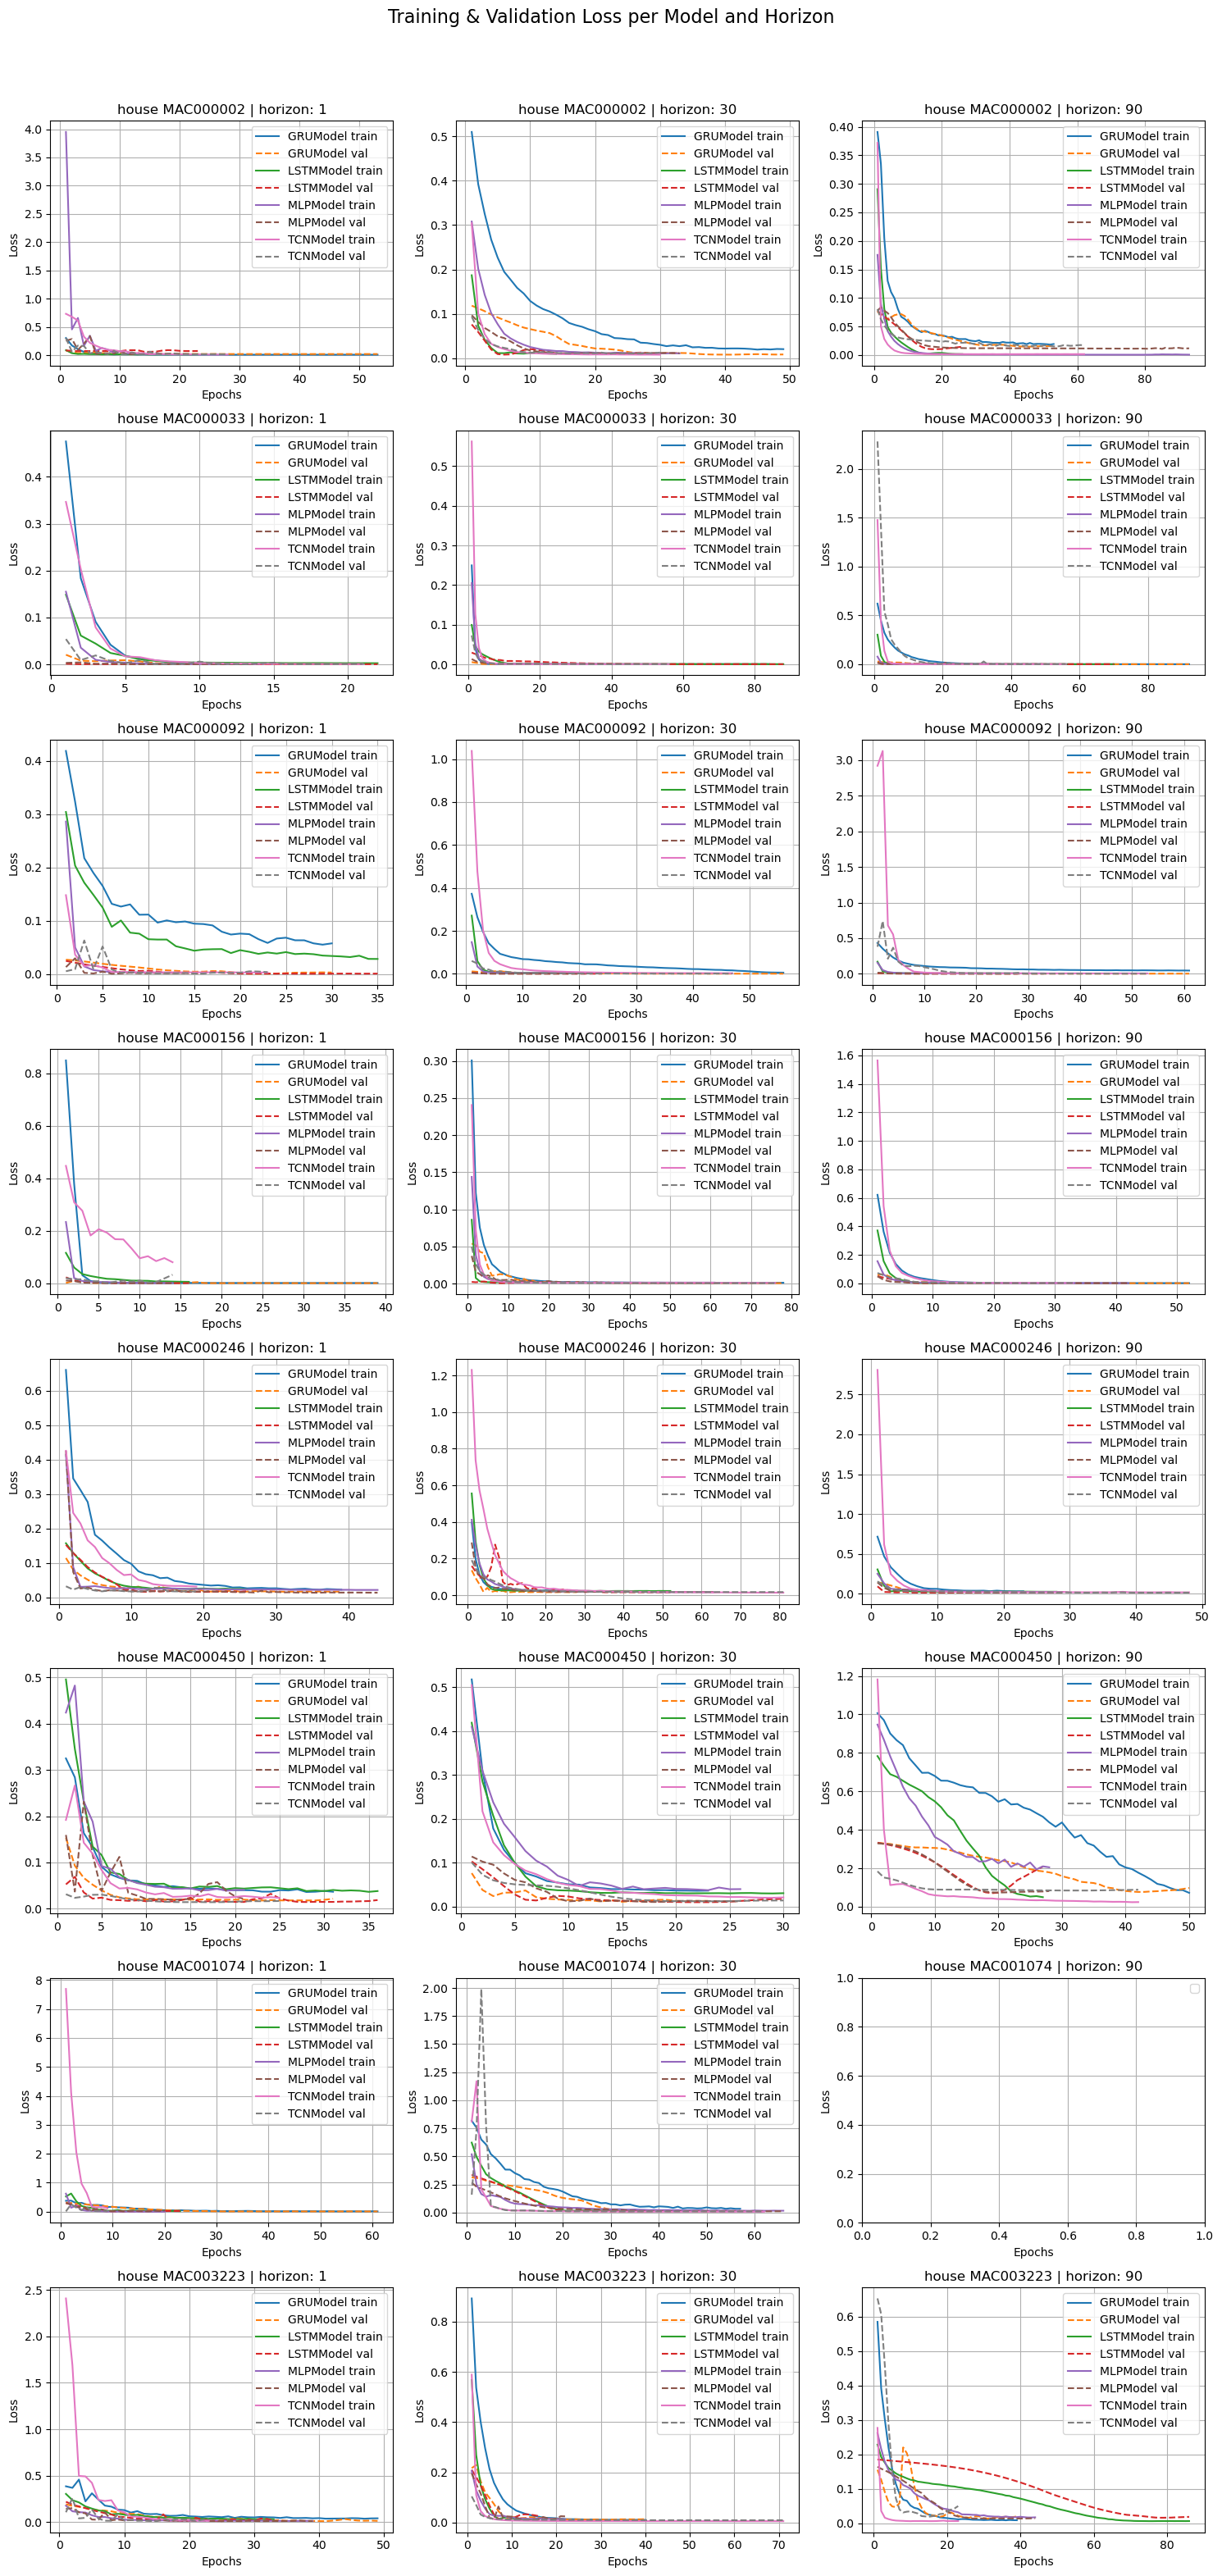

In [12]:
# Collect all horizons across all artifacts for consistent column ordering
all_horizons = sorted({hz for paths in files_by_key.values() for path in paths 
                       for hz in torch.load(path, map_location="cpu", weights_only=False).keys()
                       if hz.startswith("horizon_")})

n_rows = len(TRAINED_KEYS)
n_cols = len(all_horizons)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows), squeeze=False)
fig.suptitle("Training & Validation Loss per Model and Horizon", fontsize=16)

for i, key in enumerate(TRAINED_KEYS):
    paths = files_by_key.get(key, [])
    for j, hz_key in enumerate(all_horizons):
        ax = axes[i, j]

        for path in paths:
            artifact = torch.load(path, map_location="cpu", weights_only=False)
            # check if this horizon exists
            info = artifact.get(hz_key)
            if info is None:
                continue

            model_name = path.name.split("_")[0]  # e.g. "LSTMModel", "GRUModel"

            train_loss = info.get("train_loss")
            val_loss = info.get("val_loss")
            epochs = range(1, len(train_loss)+1)

            if train_loss is not None and val_loss is not None:
                ax.plot(epochs, train_loss, label=f"{model_name} train")
                ax.plot(epochs, val_loss, '--', label=f"{model_name} val")

        ax.set_title(f"{MODE} {key} | horizon: {hz_key.replace('horizon_', '')}")
        ax.set_xlabel("Epochs")
        ax.set_ylabel("Loss")
        ax.legend()
        ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()